In [1]:
%pwd

'/home/max/Documents/3D Vision Project/dispflownet-tf/notebooks'

In [2]:
import re
import os
import cv2
import time
import glob
import numpy as np
import tensorflow as tf
from tensorflow.python.client import timeline
import matplotlib.pyplot as plt

%matplotlib inline

# Loading Data

## FlyingThings3D
https://lmb.informatik.uni-freiburg.de/resources/datasets/SceneFlowDatasets.en.html

In [14]:
ft3d_path = '/home/max/Documents/3D Vision Project/dispflownet-tf/datasets/KITTI'
ft3d_samples_filenames = {}
for prefix in ["TRAIN", "TEST"]:
    ft3d_train_data_path = os.path.join(ft3d_path, 'training')
    #ft3d_train_labels_path = os.path.join(ft3d_path, 'disparity/TRAIN')
    left_images_filenames = sorted(glob.glob(ft3d_train_data_path + "/image_2/*"))
    right_images_filenames = sorted(glob.glob(ft3d_train_data_path + "/image_3/*"))
    #disparity_filenames = sorted(glob.glob(ft3d_train_labels_path + "/*/*/left/*"))

    ft3d_samples_filenames[prefix] = [(left_images_filenames[i],
                                       right_images_filenames[i]
                                       #disparity_filenames[i]
                                      ) for i in range(len(left_images_filenames))]

In [25]:
def read_sample(filename_queue):
    filenames = filename_queue.dequeue()
    left_fn, right_fn, disp_fn = filenames[0], filenames[1], filenames[2]
    left_img = tf.image.decode_image(tf.read_file(left_fn))
    right_img = tf.image.decode_image(tf.read_file(right_fn))
    target = tf.py_func(readPFM, [disp_fn], tf.float32)
    left_img, right_img, target = preprocess(left_img, right_img, target)
    return left_img, right_img, target

def input_pipeline(filenames, batch_size, num_epochs=None):
    filename_queue = tf.train.input_producer(
        filenames, element_shape = [3], num_epochs=num_epochs, shuffle=True)
    left_image, right_image, target = read_sample(filename_queue)
    min_after_dequeue = 100
    capacity = min_after_dequeue + 3 * batch_size
    left_image_batch, right_image_batch, target_batch = tf.train.shuffle_batch(
        [left_image, right_image, target], batch_size=batch_size, capacity=capacity,
        min_after_dequeue=min_after_dequeue)
    return left_image_batch, right_image_batch, target_batch

In [17]:
#https://lmb.informatik.uni-freiburg.de/resources/datasets/SceneFlow/assets/code/python_pfm.py

def readPFM(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline())
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data#, scale

In [18]:
def viz_sample(i):
    left_img = cv2.imread(left_images_filenames[i])
    right_img = cv2.imread(right_images_filenames[i])
    #disparity = readPFM(disparity_filenames[i])
    plt.figure(figsize=(30,30))
    plt.subplot(131)
    plt.imshow(left_img)
    plt.subplot(132)
    plt.imshow(right_img)
    #plt.subplot(133)
    #plt.imshow(disparity)
    #plt.show()

In [9]:
print(left_images_filenames)

['/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0006.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0007.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0008.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0009.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0010.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0011.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0012.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0013.png', '/media/max/Elements/Max/Datasets 3D Vision/frames_cleanpass/frames_cleanpass/TRAIN/A/0000/left/0014.png', '/media/max/Elements/Max/Datasets 3D

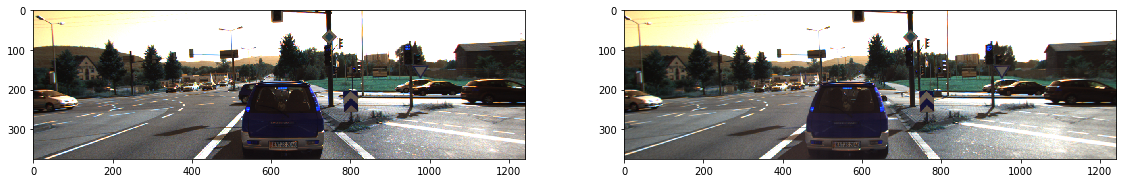

In [19]:
i = np.random.randint(len(left_images_filenames))
viz_sample(i)

# building TF graph

In [26]:
batch_size = 4
n_channels = 3
height = 384
orig_width = 960
width = 768

In [27]:
def preprocess(left_img, right_img, target):
    left_img = tf.image.convert_image_dtype(left_img, tf.float32)
    mean = tf.reduce_mean(left_img)
    left_img = left_img - mean
    right_img = tf.image.convert_image_dtype(right_img, tf.float32)
    right_img = right_img - mean
    left_img = tf.image.resize_bilinear(left_img[np.newaxis, :, :, :], [height, width])[0]
    right_img = tf.image.resize_bilinear(right_img[np.newaxis, :, :, :], [height, width])[0]
    target = tf.image.resize_nearest_neighbor(target[np.newaxis, :, :, np.newaxis], [height, width])[0]
    target = target * width / float(orig_width)
    left_img.set_shape([height, width, n_channels])
    right_img.set_shape([height, width, n_channels])
    target.set_shape([height, width, 1])
    return left_img, right_img, target

In [28]:
def correlation_map(x, y, max_disp):
    corr_tensors = []
    for i in range(-max_disp, 0, 1):
        shifted = tf.pad(tf.slice(y, [0, 0, -i, 0], [-1]*4),
                                  [[0, 0], [0, 0], [-i, 0], [0, 0]], "CONSTANT")
        corr = tf.reduce_mean(tf.multiply(shifted, y), axis=3)
        corr_tensors.append(corr)
    for i in range(max_disp + 1):
        shifted = tf.pad(tf.slice(y, [0]*4, [-1, -1, y.shape[2].value - i, -1]),
                                  [[0, 0], [0, 0], [0, i], [0, 0]], "CONSTANT")
        corr = tf.reduce_mean(tf.multiply(shifted, y), axis=3)
        corr_tensors.append(corr)
    return tf.transpose(tf.stack(corr_tensors),
                        perm=[1,2,3,0])

In [17]:
#shift_corr_module = tf.load_op_library('../tensorflow-1.1.0-rc2/tensorflow/core/user_ops/shift_corr.so')
#
#def correlation(x, y, max_disp):
#    x = tf.pad(x, [[0, 0], [0, 0], [max_disp, max_disp], [0, 0]], "CONSTANT")
#    y = tf.pad(y, [[0, 0], [0, 0], [max_disp, max_disp], [0, 0]], "CONSTANT")
#    corr = shift_corr_module.shift_corr(x, y, max_disp=max_disp)
#    return tf.transpose(corr, perm=[0, 2, 3, 1])

NotFoundError: ../tensorflow-1.1.0-rc2/tensorflow/core/user_ops/shift_corr.so: cannot open shared object file: No such file or directory

In [ ]:
#@tf.RegisterGradient("ShiftCorr")
#def _ShiftCorrOpGrad(op, grad):
#    return shift_corr_module.shift_corr_grad(op.inputs[0], op.inputs[1], grad, max_disp=max_disp)

In [29]:
leaky_alpha = 0.1
max_disp=40

initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform=False)

def conv2d(x, kernel_shape, strides=1, relu=True, padding='SAME'):
    W = tf.get_variable("weights", kernel_shape, initializer=initializer)
    b = tf.get_variable("biases", kernel_shape[3], initializer=tf.constant_initializer(0.0))
    with tf.name_scope("conv"):
        x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
        x = tf.nn.bias_add(x, b)
        tf.summary.histogram("W", W)
        tf.summary.histogram("b", b)
        if kernel_shape[2] == 3:
            x_min = tf.reduce_min(W)
            x_max = tf.reduce_max(W)
            kernel_0_to_1 = (W - x_min) / (x_max - x_min)
            kernel_transposed = tf.transpose (kernel_0_to_1, [3, 0, 1, 2])
            tf.summary.image('filters', kernel_transposed, max_outputs=3)       
        if relu : x = tf.maximum(leaky_alpha * x, x)
    return x

def conv2d_transpose(x, kernel_shape, strides=1, relu=True):
    W = tf.get_variable("weights", kernel_shape, initializer=initializer)
    b = tf.get_variable("biases", kernel_shape[2], initializer=tf.constant_initializer(0.0))
    output_shape = [batch_size,
                    x.get_shape()[1].value*strides, x.get_shape()[2].value*strides, kernel_shape[2]]
    with tf.name_scope("deconv"):
        x = tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, strides, strides, 1],
                                   padding='SAME')
        x = tf.nn.bias_add(x, b)
        if relu : x = tf.maximum(leaky_alpha * x, x)
    return x

def upsampling_block(bottom, skip_connection, input_channels, output_channels, skip_input_channels):
    with tf.variable_scope("deconv"):
        deconv = conv2d_transpose(bottom, [4, 4, output_channels, input_channels], strides=2)
    with tf.variable_scope("predict"):
        predict = conv2d(bottom, [3, 3, input_channels, 1], strides=1, relu=False)
        tf.summary.histogram("predict", predict)
    with tf.variable_scope("up_predict"):
        upsampled_predict = conv2d_transpose(predict, [4, 4, 1, 1], strides=2, relu=False)
    with tf.variable_scope("concat"):
        concat = conv2d(tf.concat([skip_connection, deconv, upsampled_predict], axis=3),
                        [3, 3, output_channels + skip_input_channels + 1, output_channels],
                        strides=1, relu=False)
    return concat, predict
    

def disp_net(left_image_batch, right_image_batch):
    with tf.variable_scope("conv1") as scope:
        conv1a = conv2d(left_image_batch, [7, 7, 3, 64], strides=2)
        scope.reuse_variables()
        conv1b = conv2d(right_image_batch, [7, 7, 3, 64], strides=2)
    with tf.variable_scope("conv2") as scope:
        conv2a = conv2d(conv1a, [5, 5, 64, 128], strides=2)
        scope.reuse_variables()
        conv2b = conv2d(conv1b, [5, 5, 64, 128], strides=2)
    with tf.variable_scope("conv_redir"):
        conv_redir = conv2d(conv2a, [1, 1, 128, 64], strides=1)
    with tf.name_scope("correlation"):
        corr = correlation_map(conv2a, conv2b, max_disp=max_disp)
    with tf.variable_scope("conv3"):
        conv3 = conv2d(tf.concat([corr, conv_redir], axis=3), [5, 5, 145, 256], strides=2)
        with tf.variable_scope("1"):
            conv3_1 = conv2d(conv3, [3, 3, 256, 256], strides=1)
    with tf.variable_scope("conv4"):
        conv4 = conv2d(conv3_1, [3, 3, 256, 512], strides=2)
        with tf.variable_scope("1"):
            conv4_1 = conv2d(conv4, [3, 3, 512, 512], strides=1)
    with tf.variable_scope("conv5"):
        conv5 = conv2d(conv4_1, [3, 3, 512, 512], strides=2)
        with tf.variable_scope("1"):
            conv5_1 = conv2d(conv5, [3, 3, 512, 512], strides=1)
    with tf.variable_scope("conv6"):
        conv6 = conv2d(conv5_1, [3, 3, 512, 1024], strides=2)
        with tf.variable_scope("1"):
            conv6_1 = conv2d(conv6, [3, 3, 1024, 1024], strides=1)
    with tf.variable_scope("up5"):
        concat5, predict6 = upsampling_block(conv6_1, conv5_1, 1024, 512, 512)
    with tf.variable_scope("up4"):
        concat4, predict5 = upsampling_block(concat5, conv4_1, 512, 256, 512)
    with tf.variable_scope("up3"):
        concat3, predict4 = upsampling_block(concat4, conv3_1, 256, 128, 256)
    with tf.variable_scope("up2"):
        concat2, predict3 = upsampling_block(concat3, conv2a, 128, 64, 128)
    with tf.variable_scope("up1"):
        concat1, predict2 = upsampling_block(concat2, conv1a, 64, 32, 64)
    with tf.variable_scope("prediction"):
        predict1 = conv2d(concat1, [3, 3, 32, 1], strides=1, relu=False)
    return (predict1, predict2, predict3,
            predict4, predict5, predict6)

In [30]:
tf.reset_default_graph()

graph = tf.Graph()

def L1_loss(x, y):
    return tf.reduce_mean(tf.abs(x - y))

with graph.as_default():
    
    loss_weights = tf.placeholder(tf.float32, shape=(6),
                                  name="loss_weights")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")
    beta1 = tf.placeholder_with_default(shape=(), name="beta1", input=0.9)
    beta2 = tf.placeholder_with_default(shape=(), name="beta2", input=0.99)
    
    training_mode = tf.placeholder_with_default(shape=(), input=True)
    
    train_pipeline = input_pipeline(ft3d_samples_filenames["TRAIN"],
                                    batch_size=batch_size, num_epochs=None)
    
    val_pipeline = input_pipeline(ft3d_samples_filenames["TEST"], batch_size=batch_size, num_epochs=None)
    
    left_image_batch, right_image_batch, target = tf.cond(training_mode,
                                                          lambda: train_pipeline,
                                                          lambda: val_pipeline)
    
    predictions = disp_net(left_image_batch, right_image_batch)
    
    with tf.name_scope("loss"):
        targets = [tf.image.resize_nearest_neighbor(target, [height / np.power(2, n),
                                                         width / np.power(2, n)])
                   for n in range(1, 7)]
        losses = [L1_loss(targets[i], predictions[i]) for i in range(6)]
        for i in range(6):
            tf.summary.scalar('loss' + str(i), losses[i])
            tf.summary.scalar('loss_weight' + str(i), loss_weights[i])
        loss = tf.add_n([losses[i]*loss_weights[i] for i in range(6)])
        tf.summary.scalar('loss', loss)

    tf.summary.image("left", tf.slice(left_image_batch, [0, 0, 0, 0], [1, -1, -1, -1]))
    tf.summary.image("right", tf.slice(right_image_batch, [0, 0, 0, 0], [1, -1, -1, -1]))
    for i in range(6):
        tf.summary.image("disp" + str(i), tf.slice(predictions[i], [0, 0, 0, 0], [1, -1, -1, -1]))
        tf.summary.image("target" + str(i), tf.slice(targets[i], [0, 0, 0, 0], [1, -1, -1, -1]))
    
    with tf.name_scope("error"):
        error = L1_loss(targets[0], predictions[0])
        tf.summary.scalar("error", error)
        
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2)
    train_step = optimizer.minimize(loss)

    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    mean_loss = tf.placeholder(tf.float32)
    tf.summary.scalar('mean_loss', mean_loss)

    merged_summary = tf.summary.merge_all()

    test_error = tf.placeholder(tf.float32)
    test_error_summary = tf.summary.scalar('test_error', test_error)
    
    saver = tf.train.Saver(max_to_keep=2)

ValueError: Shapes (2,) and (3,) are not compatible

# Training

In [51]:
import sys
import logging
import datetime

root = logging.getLogger()
root.setLevel(logging.NOTSET)
logfile = "../tflogs/dipspnet-%s.log" % datetime.datetime.today()
fileHandler = logging.FileHandler(logfile)
fileHandler.setLevel(logging.INFO)
root.addHandler(fileHandler)
consoleHandler = logging.StreamHandler(sys.stdout)
consoleHandler.setLevel(logging.DEBUG)
consoleHandler.terminator = ""
root.addHandler(consoleHandler)

logging.debug("Logging to %s" % logfile)

Logging to ../tflogs/dipspnet-2017-04-27 12:42:53.014243.log


In [101]:
weights_schedule = [[0., 0., 0., 0., 0., 1.],
                    [0., 0., 0., 0., .7, .3],
                    [0., 0., 0., .6, .3, .1],
                    [0., 0., .5, .3, .1, .1],
                    [0., .5, .3, .1, .1, 0.],
                    [.5, .3, .1, .1, 0., 0.],
                    [.6, .3, .1, 0., 0., 0.],
                    [.7, .3, 0., 0., 0., 0.],
                    [1., 0., 0., 0., 0., 0.]]

In [117]:
step = 0
LOGDIR = "/yandexsdc/tflogs/34"
MODEL_NAME = "dispnet"

try:
    os.mkdir(LOGDIR)
except:
    pass
writer = tf.summary.FileWriter(LOGDIR)

log_step = 10
schedule_step = 10000
save_step = 5000
test_step = save_step
N_test = len(ft3d_samples_filenames["TEST"]) / 20

gpu_options = tf.GPUOptions(allow_growth=True)

In [ ]:
with tf.Session(graph=graph, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    logging.debug("initialized")
#    writer.add_graph(sess.graph)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    logging.debug("queue runners started")
    try:
        feed_dict = {}
        feed_dict[training_mode] = True
        ckpt = tf.train.latest_checkpoint(".")
        if ckpt:
            logging.info("Restoring from %s" % ckpt)
            saver.restore(sess=sess, save_path=ckpt)
            step = int(ckpt[len(MODEL_NAME)+3:])
            feed_dict[loss_weights] = np.array(weights_schedule[min(step / schedule_step, len(weights_schedule)-1)])
        l_mean = 0
        start = time.time()
        feed_dict[learning_rate] = 5e-5
        feed_dict[beta1] = 0.9
        feed_dict[beta2] = 0.999
        while step < 1e5:
            if step % schedule_step == 0:
#                feed_dict[loss_weights] = np.array(weights_schedule[min(step / schedule_step, len(weights_schedule)-1)])
#                print("switching weights:")
                print(feed_dict[learning_rate])
                feed_dict[learning_rate] = feed_dict[learning_rate] / 1.4
            _, l, err  = sess.run([train_step, loss, error], feed_dict=feed_dict)
            l_mean += l
            step += 1
            if step % log_step == 0:
                l_mean = np.array(l_mean / float(log_step))
                feed_dict[mean_loss] = l_mean
                s = sess.run(merged_summary, feed_dict=feed_dict)
                writer.add_summary(s, step)
                logging.debug("iter: %d, f/b pass time: %f, loss: %f, error %f" % (step,
                    ((time.time() - start) / float(log_step)), l_mean, err))
                if np.isnan(l):
                    break
                l_mean = 0
                start = time.time()
            if step % save_step == 0:   
                logging.info("saving to file %s." % (""))
                saver.save(sess, MODEL_NAME, global_step=step)
            if step % test_step == 0:
                test_err = 0
                feed_dict[training_mode] = False
                logging.info("Testing...")
                for j in range(N_test):
                    err = sess.run([error], feed_dict=feed_dict)
                    test_err += err[0]
                test_err = test_err / float(N_test)
                logging.info("Test error %f" % test_err)
                feed_dict[test_error] = test_err
                s = sess.run(test_error_summary, feed_dict=feed_dict)
                
    except tf.errors.OutOfRangeError:
        logging.INFO('Done training for %d epochs, %d steps.' % (FLAGS.num_epochs, step))

    finally:
        coord.request_stop()
        coord.join(threads)
        sess.close()

initialized
queue runners started
Restoring from ./dispnet-90000
INFO:tensorflow:Restoring parameters from ./dispnet-90000
Restoring parameters from ./dispnet-90000
5e-05
iter: 90010, f/b pass time: 2.236852, loss: 5.934606, error 16.800577
iter: 90020, f/b pass time: 2.092398, loss: 6.426744, error 3.420483
iter: 90030, f/b pass time: 1.960537, loss: 4.347700, error 4.047184
iter: 90040, f/b pass time: 1.944237, loss: 5.253694, error 3.541281
iter: 90050, f/b pass time: 1.948414, loss: 4.132449, error 3.684876
iter: 90060, f/b pass time: 1.950235, loss: 4.150868, error 3.835644
iter: 90070, f/b pass time: 1.952570, loss: 4.171578, error 4.182681
iter: 90080, f/b pass time: 1.948278, loss: 5.393753, error 5.388224
iter: 90090, f/b pass time: 1.956631, loss: 5.067452, error 6.361891
iter: 90100, f/b pass time: 1.956548, loss: 4.336492, error 4.196795
iter: 90110, f/b pass time: 1.952049, loss: 5.461562, error 4.518213
iter: 90120, f/b pass time: 1.944312, loss: 4.775621, error 5.215955


In [126]:
err

[8.664403]

In [128]:
min(step / schedule_step, len(weights_schedule)-1)

9